In [1]:
%matplotlib inline
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.pyplot import figure
import plotly.graph_objects as go
from matplotlib.patches import Ellipse
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

## Двумерное распределение
Сгенерировать двумерные выборки размерами 20, 60, 100 для нормального двумерного распределения 𝑁(𝑥, 𝑦, 0, 0, 1, 1, 𝜌).
Коэффициент корреляции 𝜌 взять равным 0, 0.5, 0.9.
Каждая выборка генерируется 1000 раз и для неё вычисляются: среднее значение, среднее значение квадрата и дисперсия коэффициентов
корреляции Пирсона, Спирмена и квадрантного коэффициента корреляции.
Повторить все вычисления для смеси нормальных распределений:
𝑓(𝑥, 𝑦) = 0.9𝑁(𝑥, 𝑦, 0, 0, 1, 1, 0.9) + 0.1𝑁(𝑥, 𝑦, 0, 0, 10, 10, −0.9).
Изобразить сгенерированные точки на плоскости и нарисовать эллипс
равновероятности.


In [2]:
def N_(x_,y_,sigma_x,sigma_y,corr):
    mean = [x_,y_]
    sigma_xy = corr * sigma_x * sigma_y
    cov = [[sigma_x**2,sigma_xy],[sigma_xy,sigma_y**2]]
    model = st.multivariate_normal(mean=mean,cov=cov)
    def func(size):
        return model.rvs(size)
    return func

In [3]:
def r(c):
    mx = 0
    for i in range(len(c)):
        mx += c[i][0]
    mx /= len(c)

    my = 0
    for i in range(len(c)):
        my += c[i][1]
    my /= len(c)

    K = 0
    for i in range(len(c)):
        K += (c[i][0] - mx) * (c[i][1] - my)
    K /= len(c)


    dx = 0
    for i in range(len(c)):
        dx += (c[i][0] - mx)**2
    dx/= len(c)

    dy = 0
    for i in range(len(c)):
        dy += (c[i][1] - my)**2
    dy/= len(c)

    r = K/(dx*dy)**0.5

    return r

In [4]:
def getMed(array):
    x = array[:,0].copy()
    y = array[:,1].copy()
    
    x.sort()
    y.sort()
    
    if(len(x) % 2 == 0):
        x_med = (x[len(x)//2] + x[len(x)//2 - 1])/2
    else:
        x_med = x[len(x)//2]
        
    if(len(y) % 2 == 0):
        y_med = (y[len(y)//2] + y[len(y)//2 - 1])/2
    else:
        y_med = y[len(y)//2]
    
    return (x_med,y_med)

def rq(array):
    n1 = 0
    n2 = 0
    n3 = 0
    n4 = 0
    
    (x_med,y_med) = getMed(array)
 
    for i in range(len(array)):
        if (array[i][0] >= x_med) and (array[i][1] >= y_med):
            n1 += 1
        if (array[i][0] < x_med) and (array[i][1] >= y_med):
            n2 += 1
        if (array[i][0] < x_med) and (array[i][1] < y_med):
            n3 += 1
        if (array[i][0] >= x_med) and (array[i][1] < y_med):
            n4 += 1
    return ((n1 + n3) - (n2 + n4))/len(array)

In [5]:
def rS(array_2d):
    mx = (len(array_2d) + 1)/2
    my = (len(array_2d) + 1)/2
    
    x = array_2d[:,0].copy()
    y = array_2d[:,1].copy()
    
    x.sort()
    y.sort()
    
    xMap = dict()
    yMap = dict()
    
    for i in range(len(x)):
        xMap[x[i]] = i + 1
    
    for i in range(len(y)):
        yMap[y[i]] = i + 1

    K = 0
    for i in range(len(array_2d)):
        K += (xMap[array_2d[i][0]] - mx) * (yMap[array_2d[i][1]] - my)
    K /= len(array_2d)


    dx = 0
    for i in range(len(array_2d)):
        dx += (xMap[array_2d[i][0]] - mx)**2
    dx/= len(array_2d)

    dy = 0
    for i in range(len(array_2d)):
        dy += (yMap[array_2d[i][1]] - my)**2
    dy/= len(array_2d)

    val = K/(dx*dy)**0.5

    return val

In [33]:
def getMean1(array):
    sm = 0
    for val in array:
        sm += val
    sm /= len(array)
    return sm

def getMean2(array):
    sm = 0
    for val in array:
        sm += val**2
    sm /= len(array)
    return sm

def getDis(array):
    sm = 0
    mn = getMean1(array)
    for i in array:
        sm += (i - mn) ** 2
    return sm/ len(array)

def getMetricsRepeat(func,size = 100, iterations = 1000):
    array = func(size)
    ar = [[rS(array),rq(array),r(array)]]
    for i in range(999):
        array = func(size)
        ar = np.concatenate(([[r(array),rS(array),rq(array)]],ar),axis = 0)
    disp = []
    mean = []
    mean2 = []
    for i in range(len(ar[0])):
        mean.append(getMean1(ar[:,i]))
        disp.append(round(getDis(ar[:,i]),2))
        mean2.append(getMean2(ar[:,i]))
        
    return {'mean':mean,
            'disp' : disp,
            'mean2' : mean2
           }

def Draw(func,size):
    d = getMetricsRepeat(func,size)
    vals = ['r','rS','rQ']
    col = [['mean1'] + ['mean2'] + ['disp']]
    for i in range(0,len(d['mean'])):
        col.append([d['mean'][i]] + [d['mean2'][i]] + [d['disp'][i]] )
    fig = go.Figure(data=[go.Table(
        header=dict(values=['n = ' +str(size)] + vals,
                    line_color='darkslategray',
                    fill_color='lightskyblue',
                    align='left',
         ),
        cells=dict(values=col, # 2nd column
                   line_color='darkslategray',
                   fill_color='lightcyan',
                   align='left',
                  format = ["",".3f"]))
    ])

    fig.update_layout(width=1000, height=300)
    fig.show()

In [34]:
def func(size = 20):
    f1 = N_(0,0,1,1,0.9)
    f2 = N_(0,0,10,10,-0.9)
    return 0.9*f1(size) + 0.1 * f2(size)

In [32]:
f = N_(0,0,1,1,0)
Draw(f,20)
Draw(f,60)
Draw(f,100)

[[-0.0926475  -0.05263158  0.2       ]
 [ 0.25388522  0.2406015   0.        ]
 [-0.20098855 -0.12631579  0.2       ]
 ...
 [-0.21566541 -0.1593985   0.        ]
 [ 0.01787211  0.06015038  0.        ]
 [-0.02105263  0.         -0.07582743]]


[[ 0.11912798  0.04245624  0.06666667]
 [ 0.0846401   0.08924701  0.06666667]
 [ 0.04382918 -0.06618505 -0.13333333]
 ...
 [-0.00780343 -0.03745485 -0.06666667]
 [ 0.02510457  0.06507363  0.13333333]
 [-0.06218394 -0.06666667 -0.0544143 ]]


[[ 0.03405508  0.07680768  0.12      ]
 [ 0.11703558  0.12151215  0.08      ]
 [ 0.0223001  -0.00783678  0.08      ]
 ...
 [-0.09166372 -0.12553255 -0.08      ]
 [ 0.00057054 -0.02622262 -0.04      ]
 [-0.12133213 -0.04       -0.1550553 ]]


In [9]:
f = N_(0,0,1,1,0.5)
Draw(f,20)
Draw(f,60)
Draw(f,100)

In [10]:
f = N_(0,0,1,1,0.9)
Draw(f,20)
Draw(f,60)
Draw(f,100)

In [16]:
Draw(func,20)
Draw(func,60)
Draw(func,100)

In [17]:
def ellipse(point,x_med,y_med,sigma_x,sigma_y,r):
    
    a = sigma_x
    b = sigma_y
    
    alpha = np.arctan(((2 * r * a * b) /(a**2 - b**2)))/2

    
    a_ = (a **2 * np.cos(alpha) ** 2 + r*a*b*np.sin(2*alpha) + b**2 * np.sin(alpha) ** 2) ** 0.5
    b_ = (a **2 * np.sin(alpha) ** 2 - r*a*b*np.sin(2*alpha) + b**2 * np.cos(alpha) ** 2) ** 0.5

    xVal = point[0]
    yVal = point[1]
    
    point[0] = xVal * np.cos(-alpha) - yVal * np.sin(-alpha)
    point[1] = xVal * np.sin(-alpha) + yVal * np.cos(-alpha)
    
    lambd = ((point[0]**2) /(a_**2) + (point[1]**2)/(b_**2))**0.5 
    
    a_ *= lambd
    b_ *= lambd
    
    t = np.linspace(0,2 * 3.14,1000)
    
    x_ =a_* np.cos(t)
    y_ =b_* np.sin(t) 
    
    x = x_
    y = y_
    
    x_ = x*np.cos(alpha) - y* np.sin(alpha) + x_med
    y_ = x*np.sin(alpha) + y * np.cos(alpha) + y_med
    
    return [x_,y_]

def Ellip(point,x_med,y_med,sig,r):
    
    alpha = 45
    
    a_ = sig/((1 - r)**0.5) 
    b_ = sig/((1 + r)**0.5) 
    
    x = point[0]
    y = point[1]
    
    point[0] = x * np.cos(-alpha * np.pi/180) - y * np.sin(-alpha*np.pi/180)
    point[1] = x * np.sin(-alpha * np.pi/180) + y * np.cos(-alpha*np.pi/180)
    
    lambd = ((point[0]**2) /(a_**2) + (point[1]**2)/(b_**2))**0.5 
    
    a_ *= lambd * 1.001 
    b_ *= lambd * 1.001
    
    el = Ellipse((0,0),width=a_ * 2,height=b_ * 2,angle = alpha,edgecolor='r', fc='None', lw=2)
    
    return el
    

def DrawEllipse(ax,fc,size):
    
    array = fc(size=size)
    val_max = array[np.argmin(array[:,0])]
    
    #calc metrics
    cov = np.cov(array[:,0],array[:,1])
    sm_x = cov[0,0] ** 0.5
    sm_y = cov[1,1] ** 0.5
    x_mn = array[:,0].mean()
    y_mn = array[:,1].mean()
    p_coeff = cov[0,1]/(cov[1,1] * cov[0,0]) ** 0.5
    
    # Draw plots
    ax.scatter(x = array[:,0],y = array[:,1])
    if(sm_x == sm_y):
        ax.add_patch(Ellip(val_max,x_mn,y_mn,sm_x,p_coeff))
    else:
        (x,y) = ellipse(val_max,x_mn,y_mn,sm_x,sm_y,p_coeff)
        ax.plot(x,y,color='r', lw=2)
    

In [18]:
def EllipseTable(x_,y_,sigma_x,sigma_y,size):
    fig, ax = plt.subplots(1, 3, sharey=True)

    fig.set_figheight(3)
    fig.set_figwidth(10)
    
    corr = [0,0.5,0.9]
    
    for i in range(len(corr)):
        ax[i].set_title("n = " + str(size) + ", rho = " + str(corr[i]))
        fc = N_(x_,y_,sigma_x,sigma_y,corr[i])
        DrawEllipse(ax[i],fc,size)
    plt.show()

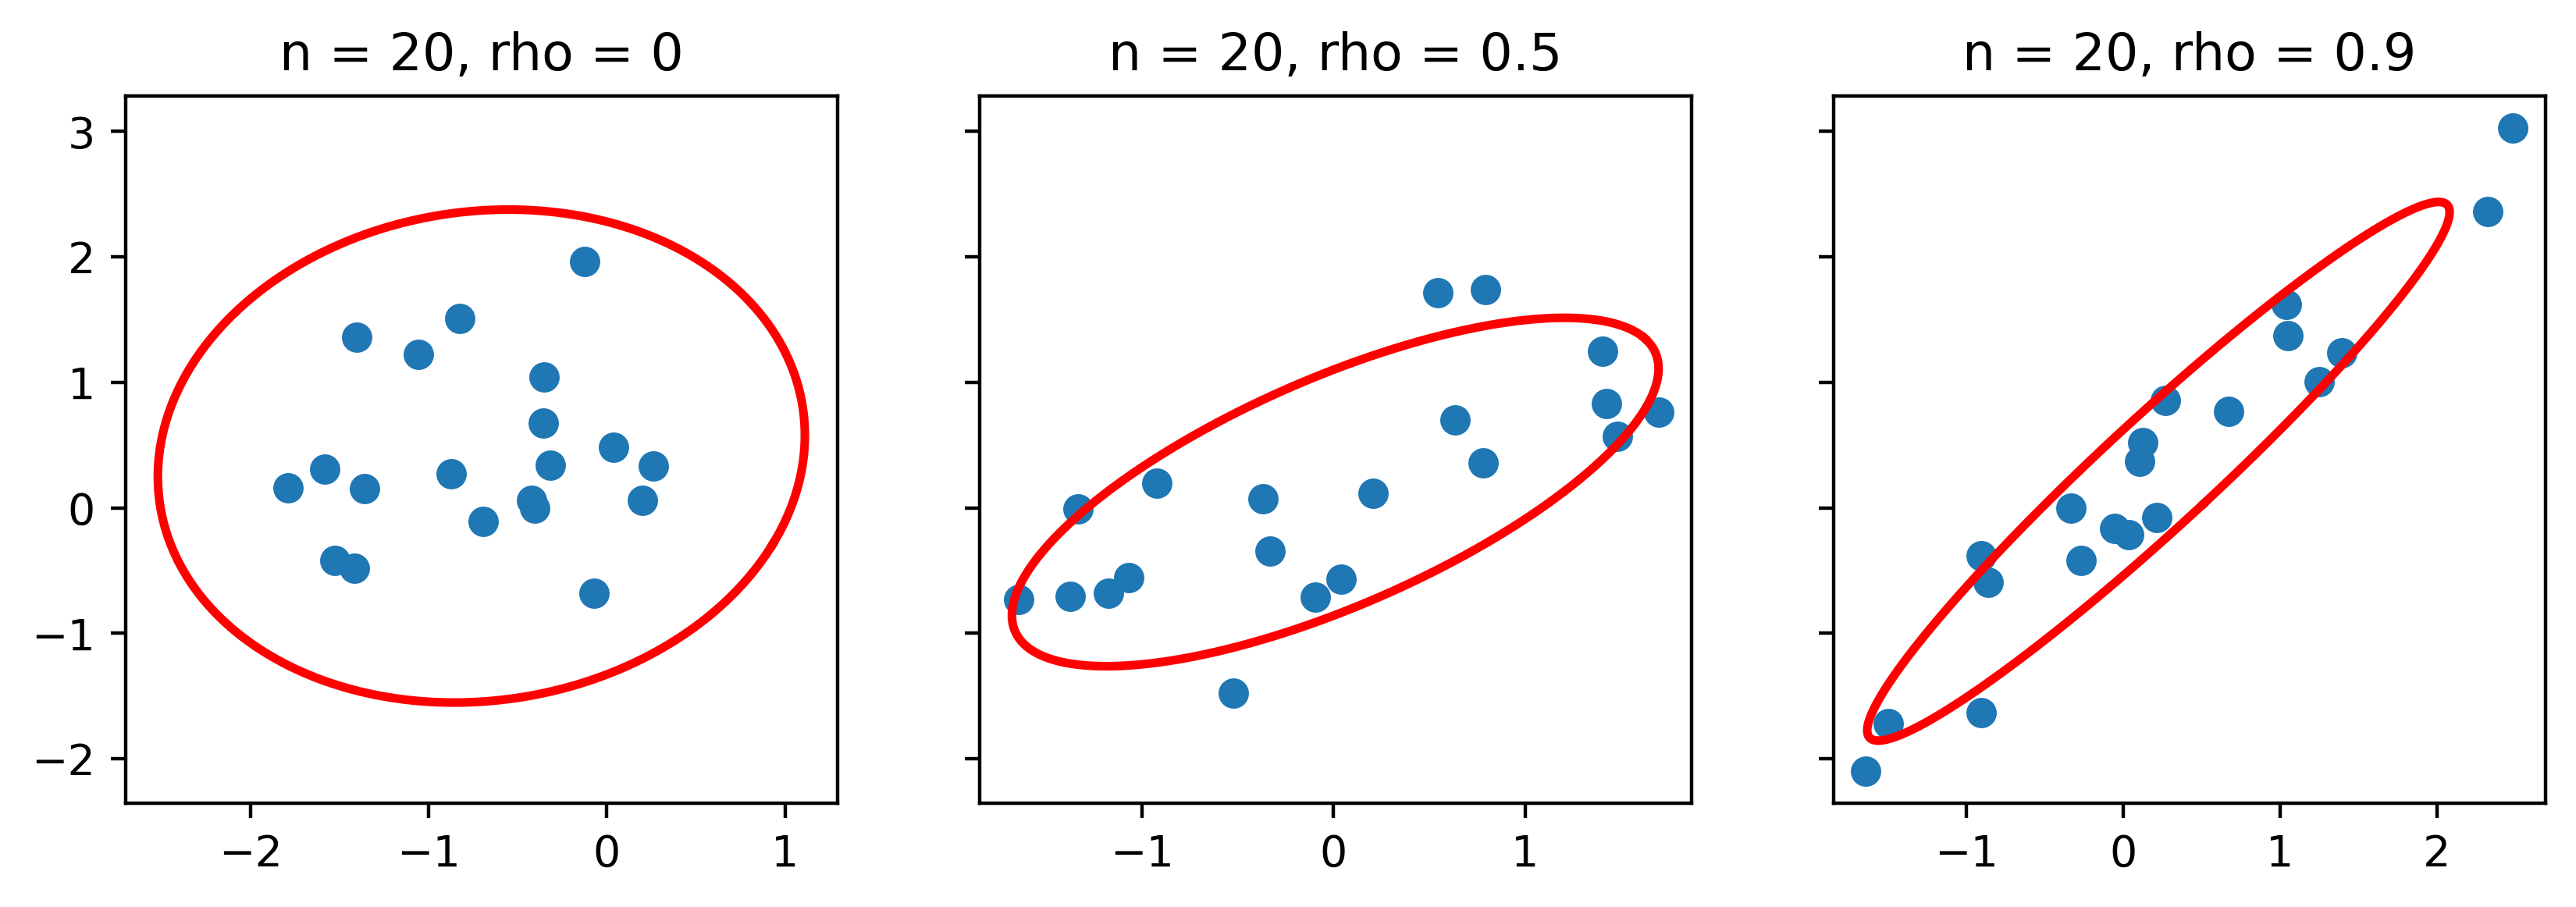

In [22]:
EllipseTable(0,0,1,1,size=20)

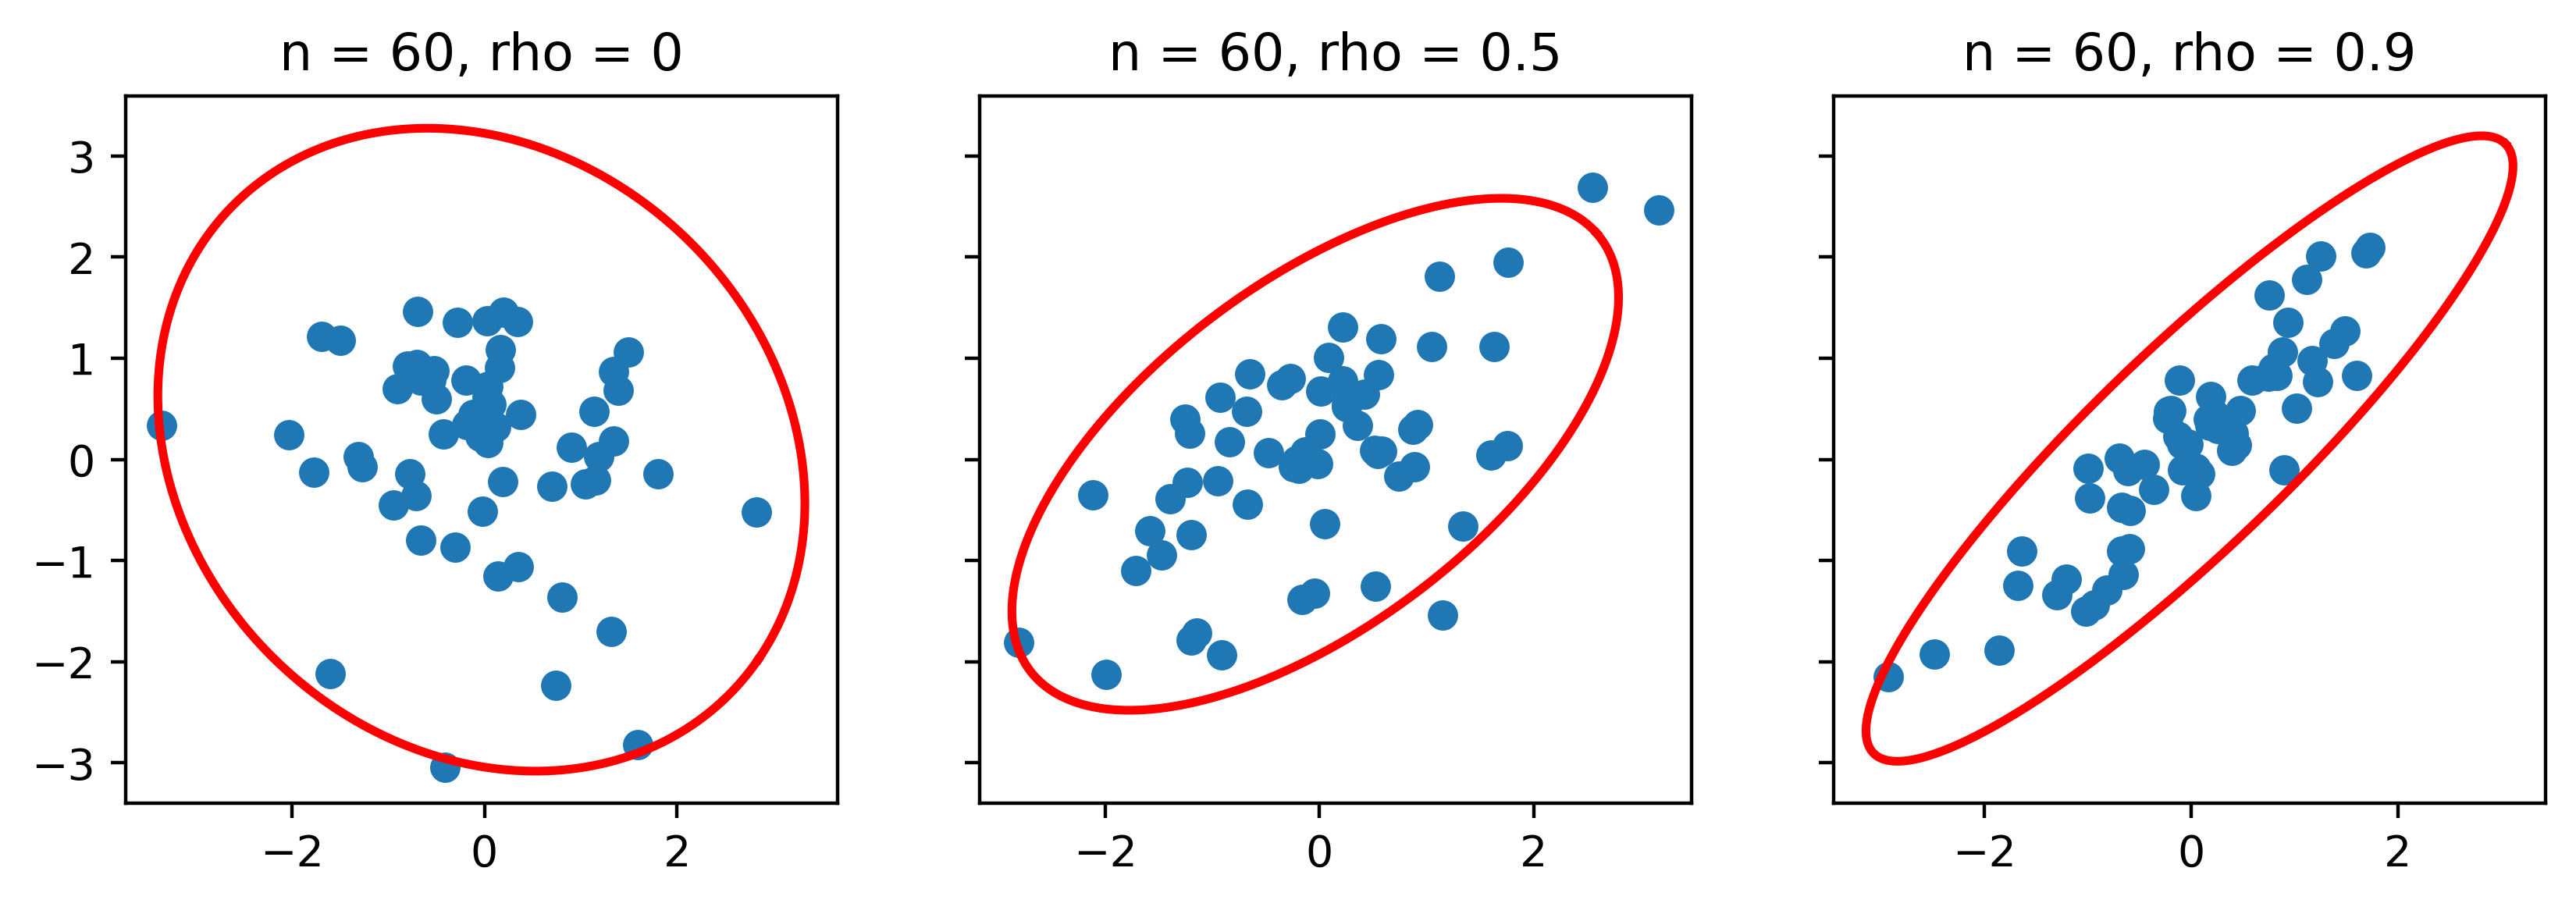

In [14]:
EllipseTable(0,0,1,1,size=60)

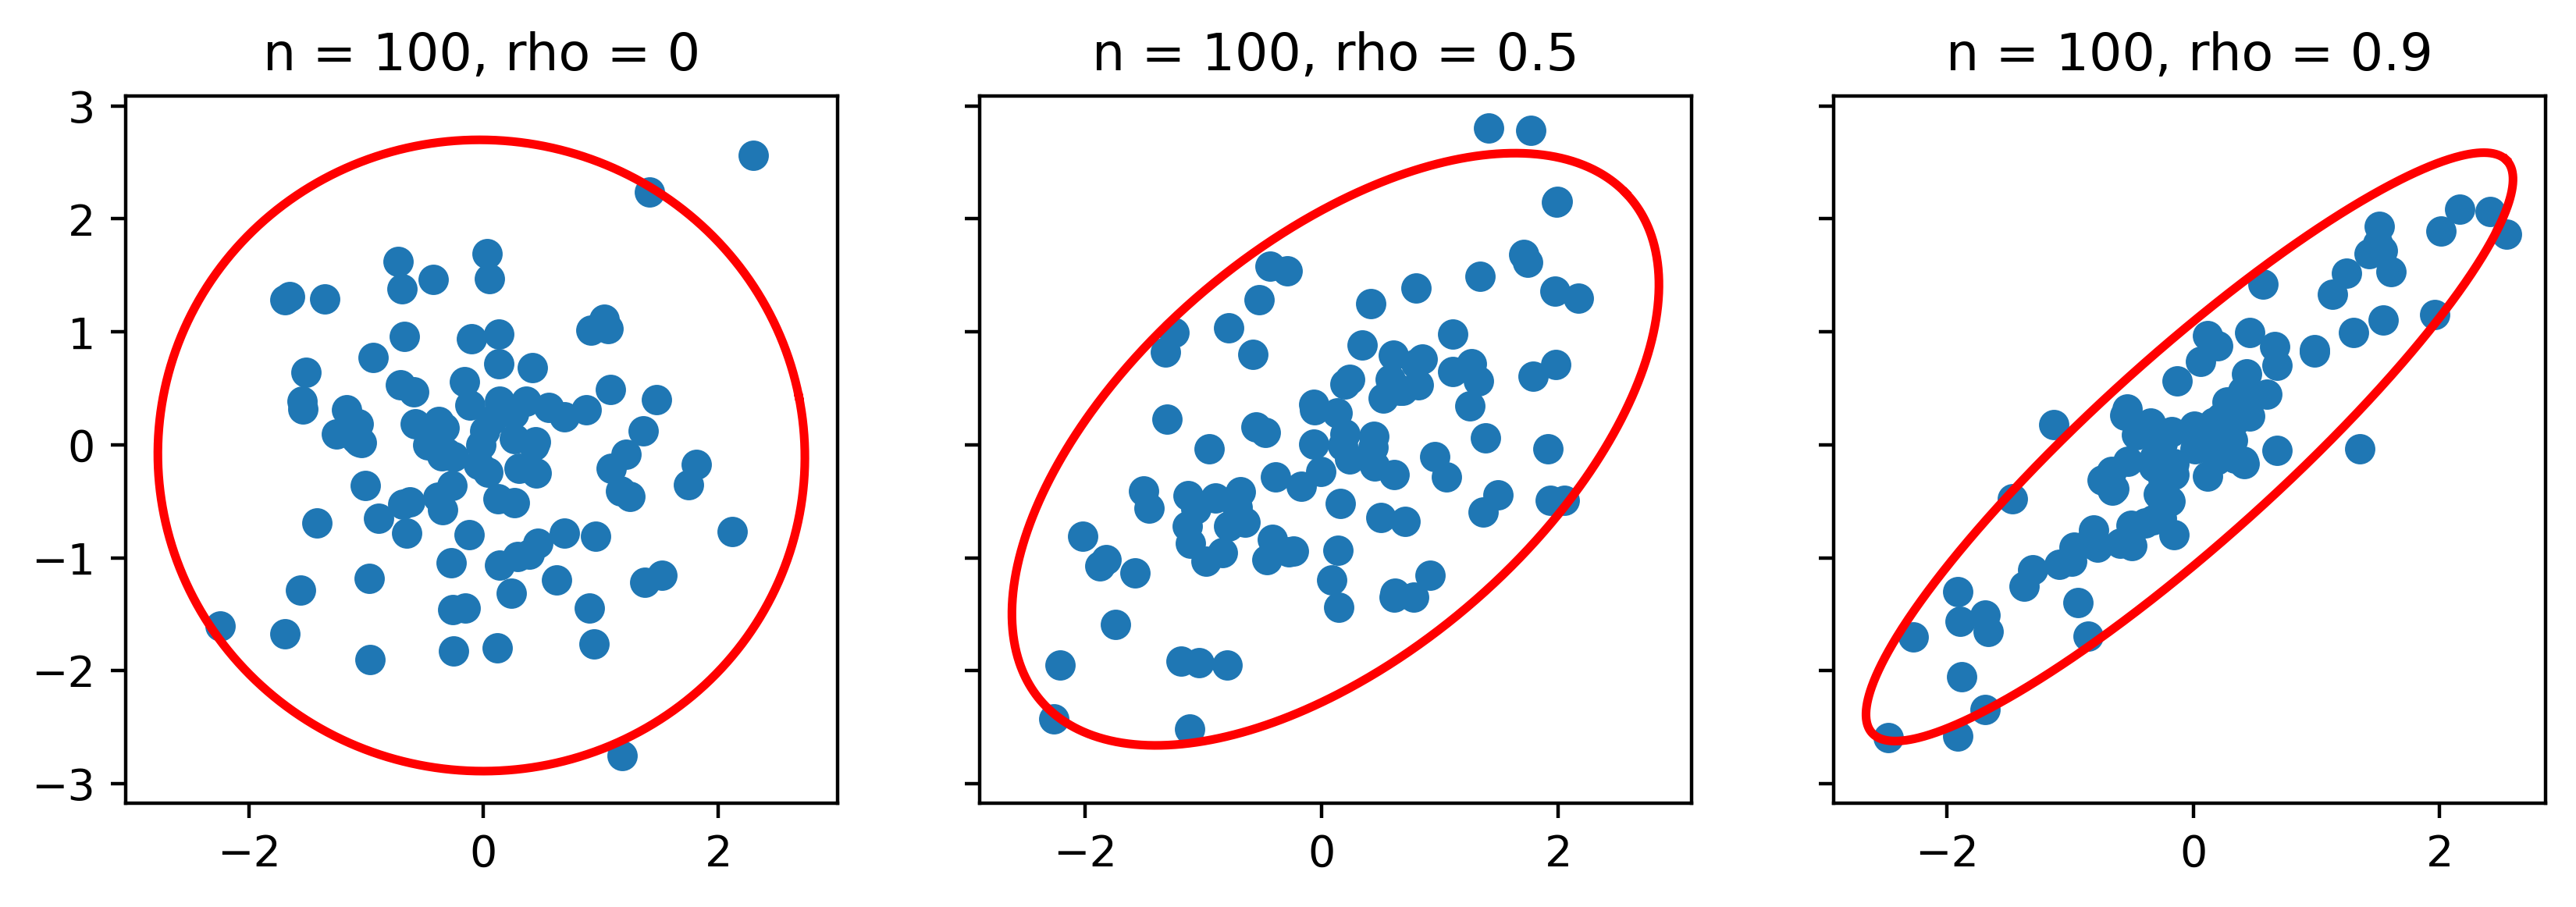

In [23]:
EllipseTable(0,0,1,1,size=100)